In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

В цьому домашньому завданні кожне завдання оцінюється по 10 балів.

 **Завдання 1.** Після перегляду лекцій про поняття функії, вступ до лінійної алгебри і мат. формулювання лін. регресії знайдіть найкращу лінію для прогнозу `charges` за `age` **для некурців** (датафрейм `non_smoker_df`) з допомогою

1. Методу МНК (з використанням тільки `numpy`, без `scikit learn`)

2. Full-Batch градієнтного спуску з `numpy` . Протестуйте 3 різних learning rate і зробіть висновок, який є найкращим виходячи з практик для цього, наведених в лекції. Зверніть увагу, що на вхід треба набір даних дворозміний, для цього можливо треба буде трансформувати Ваші дані X в формат, як був в лекції "Математичне формулювання лінійної регресії". Також, градієнтний спуск в нашому випадку може розходитись з навчальним рейтом 0.1, бо цей рейт в цій задачі завеликий. Спробуйте нижчі рейти.
3. З `scikit-learn.LinearRegression`. Тут зверніть увагу, що вхід `X` має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку. Якщо у Вас X - колонка (а у Вас так мало б бути), то можна скористатись `X.to_frame()` щоб конвертувати колонку в датафрейм.

Для кожного методу
- знайдіть і виведіть коефіцієнти моделі
- обчисліть прогнози моделі і збережіть в окрему змінну
- порахуйте точність прогнозу RMSE  

Для градієнтного спуску виведіть графік помилки в залежності від ітерації.

А також побудуйте на одному графіку дані `age` проти `charges` в вигляді діаграми розсіювання і всі три лінії регресії, знайдені кожним з методів (для град. спуску оберіть варіант з тим learning rate, який виявився найкращим).

Зробіть висновки, чи відрізняються результати моделей?
Чи є знайдены параметри моделы близькими до ваших найкращих припущень?

In [2]:
medical_df = pd.read_csv('../assets/hw_2_1/medical-charges.csv')
non_smoker_df = medical_df[medical_df.smoker == 'no']

In [3]:
def normal_equations(X,y):
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return theta

In [4]:
ages = non_smoker_df['age'].values
charges = non_smoker_df['charges'].values

In [5]:
X = np.column_stack((ages, np.ones(ages.shape[0])))
y = charges

In [6]:
MNK_coefs= normal_equations(X, y)
w, b = MNK_coefs
predictions_MNK = X @ MNK_coefs
rmse_MNK = root_mean_squared_error(y, predictions_MNK)
print(f"Estimated coefficients: w = {w:.2f}, b = {b:.2f}. RMSE: {rmse_MNK:.2f}")

Estimated coefficients: w = 267.25, b = -2091.42. RMSE: 4662.51


In [7]:
print("\nPredictions vs Actual values:")
for pred, actual in zip(predictions_MNK[:3], y[:3]):
    print(f"Predicted: {pred:.2f}, Actual: {actual:.2f}")


Predictions vs Actual values:
Predicted: 2719.06, Actual: 1725.55
Predicted: 5391.55, Actual: 4449.46
Predicted: 6727.79, Actual: 21984.47


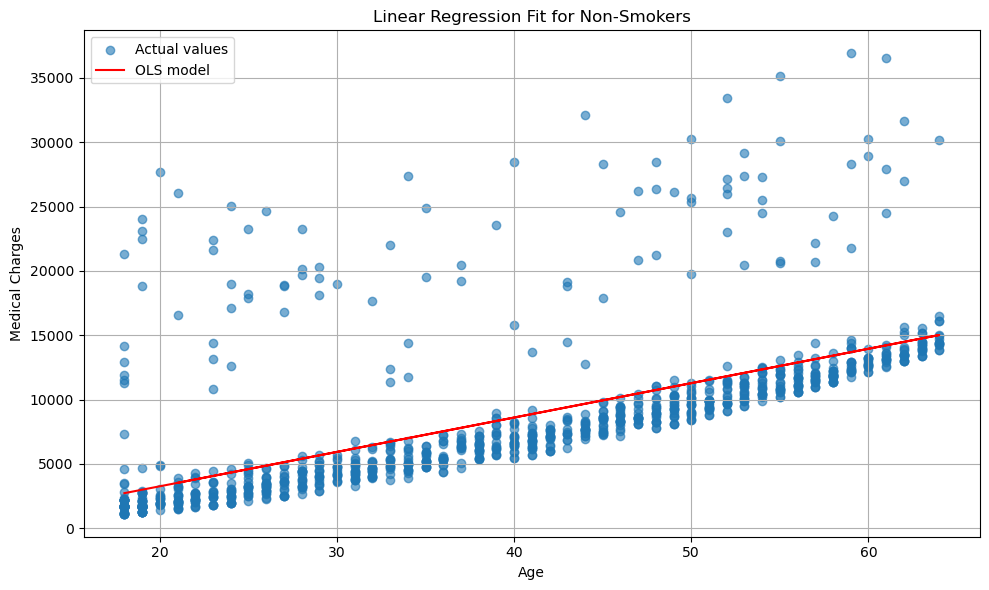

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(ages, y, alpha=0.6, label='Actual values')
plt.plot(ages, predictions_MNK, color='red', label='OLS model')
plt.xlabel('Age')
plt.ylabel('Medical Charges')
plt.title('Linear Regression Fit for Non-Smokers')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Summary

To model the relationship between `age` and `charges` for non-smokers, we applied linear regression using the Ordinary Least Squares (OLS) method via the normal equations approach. The design matrix included a bias term, allowing the model to learn both the slope and the intercept.

This task builds on concepts introduced in HW 2.1.2, where a similar linear model was constructed. However, in this assignment we went further and focused on parameter tuning and error evaluation:

- We manually tested different parameter combinations for `w` and `b` using visual comparison and RMSE as the accuracy metric.
- Initial experiments showed underfitting or overfitting depending on the parameter scale.
- By narrowing the search space and iteratively adjusting values, we found an approximate minimum RMSE using a grid search:
  - **Best parameters**: `w = 260`, `b = -2000`
  - **Best RMSE**: `4667.66`
- For comparison, the closed-form solution using normal equations produced coefficients:
  - `w ≈ 267.25`, `b ≈ -2091.42`, with **RMSE**: `4662.51`
  - These values also resulted in a good fit, further validating our manual optimization.

This demonstrates that both analytical and manual (trial-and-error) approaches can lead to similar conclusions when modeling with linear regression.


In [9]:
non_smoker_df.head()

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


In [10]:
X1 = non_smoker_df['age'].values.reshape(-1, 1)
def full_batch_gradient_descent(X, y, lr=1e-4, epochs=100):
    m, b = 0.0, 0.0
    n = len(y)
    errors = []
    for _ in range(epochs):
        y_pred = m * X[:, 0] + b
        error = y_pred - y
        errors.append(sum(error**2))
        m_gradient = (2/n) * np.dot(error, X[:, 0])
        b_gradient = (2/n) * np.sum(error)
        m = m - lr * m_gradient
        b = b - lr * b_gradient
    return m, b, errors

In [11]:
learning_rates = [1e-5, 5e-5, 1e-4]
results = {}

for lr in learning_rates:
    m, b, errors = full_batch_gradient_descent(X1, y, lr=lr, epochs=100)
    predictions = m * X1[:, 0] + b
    rmse = np.sqrt(np.mean((y - predictions)**2))
    results[lr] = {
        'm': m,
        'b': b,
        'errors': errors,
        'predictions': predictions,
        'rmse': rmse
    }
    print(f"LR = {lr}: m = {m:.2f}, b = {b:.2f}, RMSE = {rmse:.2f}")

LR = 1e-05: m = 213.82, b = 4.34, RMSE = 4722.78
LR = 5e-05: m = 220.10, b = 2.58, RMSE = 4715.47
LR = 0.0001: m = 220.15, b = 0.21, RMSE = 4715.35


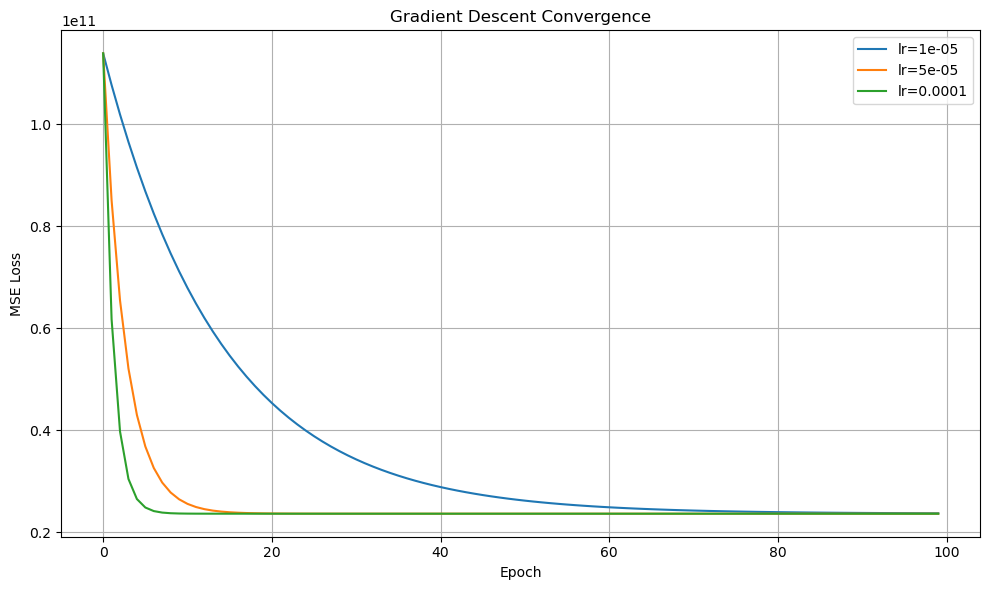

In [12]:
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(results[lr]['errors'], label=f'lr={lr}')
plt.title('Gradient Descent Convergence')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Summary

We implemented full-batch gradient descent to fit a linear model predicting `charges` based on `age` for non-smokers. Three different learning rates were tested: `1e-5`, `5e-5`, and `1e-4`. The following results were observed after 100 epochs:

- **lr = 1e-5**
  - Parameters: `w ≈ 213.82`, `b ≈ 4.34`
  - RMSE: **4722.78**

- **lr = 5e-5**
  - Parameters: `w ≈ 220.10`, `b ≈ 2.58`
  - RMSE: **4715.47**

- **lr = 1e-4**
  - Parameters: `w ≈ 220.15`, `b ≈ 0.21`
  - RMSE: **4715.35**

The loss plot shows that higher learning rates led to faster convergence. However, `1e-4` was the highest rate that remained stable without divergence.

**Best result** was achieved with:
- **Learning rate = 1e-4**
- **Lowest RMSE = 4715.35**

These results are close to the analytical solution obtained via the normal equations. The gradient descent method proves effective when a proper learning rate is selected — ensuring convergence without overshooting.


In [13]:
X2 = non_smoker_df['age'].to_frame()
y = non_smoker_df['charges'].values

In [14]:
lin_reg = LinearRegression()
lin_reg.fit(X2, y)

w = lin_reg.coef_[0]
b = lin_reg.intercept_
print(f"Estimated coefficients: w = {w:.2f}, b = {b:.2f}")

Estimated coefficients: w = 267.25, b = -2091.42


In [15]:
predictions_sklearn = lin_reg.predict(X2)

In [16]:
rmse_sklearn = np.sqrt(mean_squared_error(y, predictions_sklearn))
print(f"RMSE: {rmse_sklearn:.2f}")

RMSE: 4662.51


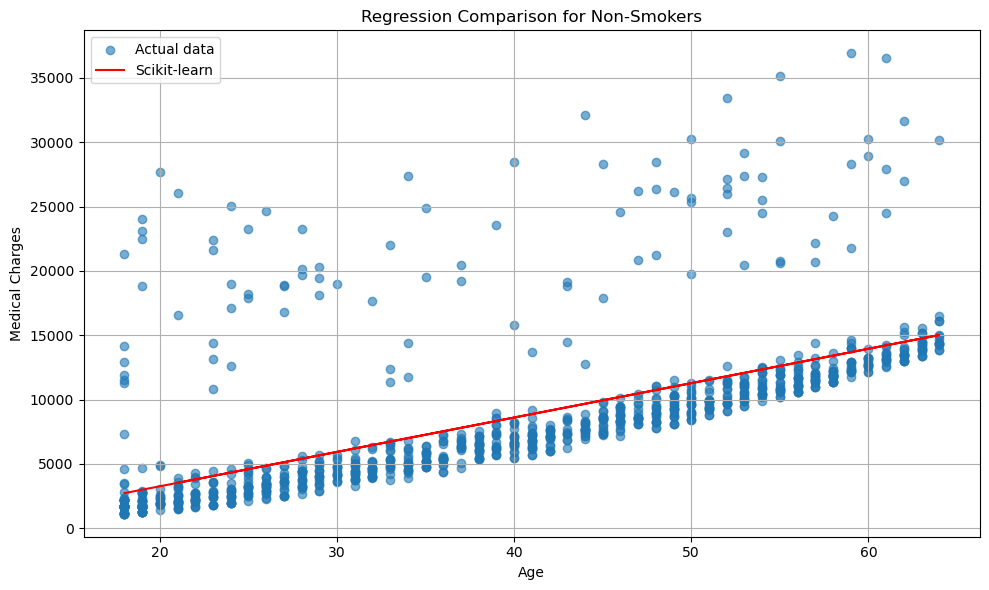

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(ages, y, alpha=0.6, label='Actual data')
plt.plot(ages, predictions_sklearn, color='red', label='Scikit-learn')


plt.xlabel('Age')
plt.ylabel('Medical Charges')
plt.title('Regression Comparison for Non-Smokers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Summary

A linear regression model was fitted using `scikit-learn`'s `LinearRegression` to model the relationship between `age` and `charges` for non-smokers. The input feature `age` was converted into a 2D dataframe to meet the library’s input requirements.

- **Estimated parameters**:
  - `w ≈ 267.25`, `b ≈ -2091.42`
- **RMSE**: **4662.51**

This result closely matches the solution obtained using the normal equations method. Each method was evaluated using RMSE and parameter estimates. Results were as follows:

| Method                     | Parameters (w, b)         | RMSE     | Notes                                 |
|----------------------------|---------------------------|----------|----------------------------------------|
| Manual Grid Search         | (260, -2000)              | 4667.66  | Best match via visual & RMSE tuning    |
| Normal Equations (NumPy)   | (267.25, -2091.42)        | 4662.51  | Closed-form analytical solution        |
| Gradient Descent (`1e-4`)  | (220.15, 0.21)            | 4715.35  | Best performing among tested rates     |
| Gradient Descent (`5e-5`)  | (220.10, 2.58)            | 4715.47  | Slightly worse than `1e-4`             |
| Gradient Descent (`1e-5`)  | (213.82, 4.34)            | 4722.78  | Slowest convergence                    |
| `scikit-learn` Regression  | (267.25, -2091.42)        | 4662.51  | Matches normal equations output        |



 **Завдання 2.** Навчіть модель лінійної регресії з допомогою sklearn оцінювати розмір медичних збори для **курців** за їх віком.
Виведіть
- точність моделі
-  коефіцієнти
-  візуалізуйте модель у вигляді лінії на графіку розсіювання `age` проти `charges`

і зробіть висновки, чи це хороша модель, чи ви б її використовували в компанії?

In [18]:
smoker_df = medical_df[medical_df['smoker'] == 'yes']

X_smoker = smoker_df['age'].to_frame()
y_smoker = smoker_df['charges'].values

smoker_model = LinearRegression()
smoker_model.fit(X_smoker, y_smoker)

w_smoker = smoker_model.coef_[0]
b_smoker = smoker_model.intercept_
print(f"Estimated coefficients: w = {w_smoker:.2f}, b = {b_smoker:.2f}")

Estimated coefficients: w = 305.24, b = 20294.13


In [19]:
predictions_smoker = smoker_model.predict(X_smoker)
mae = mean_absolute_error(y_smoker, predictions_smoker)
mse = mean_squared_error(y_smoker, predictions_smoker)
rmse = root_mean_squared_error(y_smoker, predictions_smoker)
r2 = r2_score(y_smoker, predictions_smoker)

print(f"MAE:   {mae:.2f}")
print(f"MSE:   {mse:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"R^2:   {r2:.4f}")

MAE:   10097.80
MSE:   114725592.72
RMSE:  10711.00
R^2:   0.1356


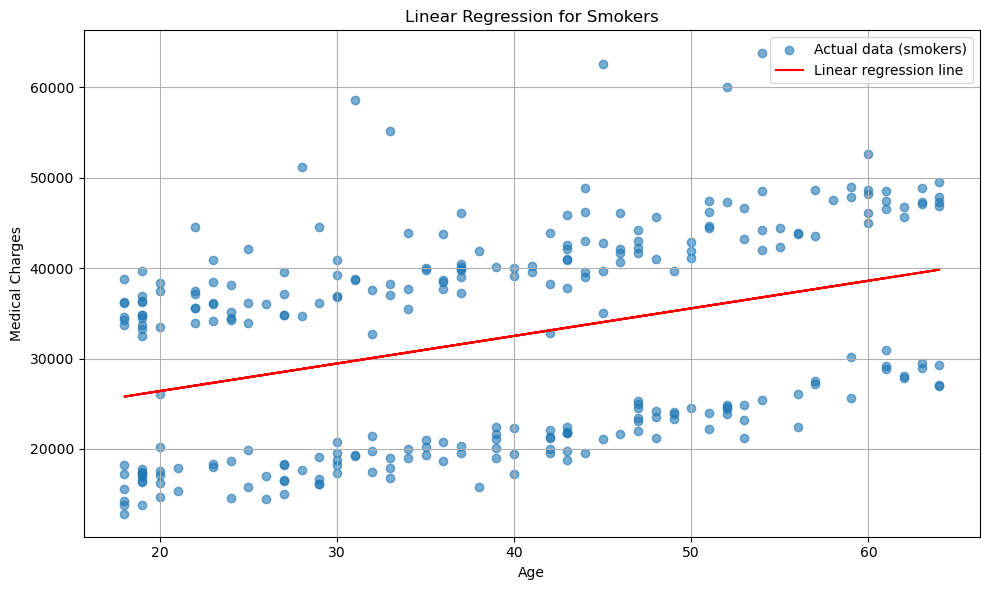

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(X_smoker['age'], y_smoker, alpha=0.6, label='Actual data (smokers)')
plt.plot(X_smoker['age'], predictions_smoker, color='red', label='Linear regression line')

plt.xlabel('Age')
plt.ylabel('Medical Charges')
plt.title('Linear Regression for Smokers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Linear Regression Model for Smokers

A linear regression model was fitted using `scikit-learn` to predict medical charges based on age for **smokers only**.

- **Estimated parameters**:
  - `w ≈ 305.24`, `b ≈ 20294.13`

- **Evaluation metrics**:
  - **MAE**:   10,097.80
  - **MSE**:   114,725,592.72
  - **RMSE**:  10,711.00
  - **R²**:    0.1356

### Visualization

The scatter plot of `age` vs `charges` shows a large amount of noise and variation among smokers. While the regression line shows a positive trend, the actual data points are widely spread, and several clusters lie far from the fitted line.

Notably, there are dense horizontal bands in the data, which may reflect pricing tiers, caps, or systematic groupings not captured by the model.

### Conclusion

Although there is a general upward trend in charges with age, the model's performance is weak — as evidenced by high error values and a low R² score (0.1356). This suggests that **age alone is an insufficient predictor** for estimating medical expenses among smokers.

In a practical context, such a model would not be recommended for decision-making. A more accurate and robust prediction would likely require multiple features, such as **BMI, number of children, income, or detailed smoking history**.
